ticker is NVDA


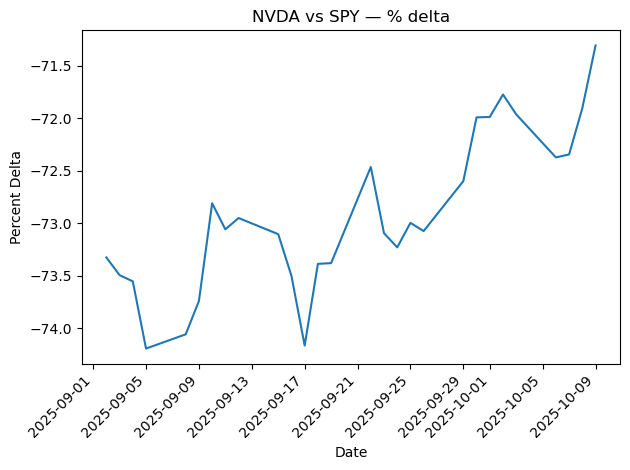

ticker is AAPL


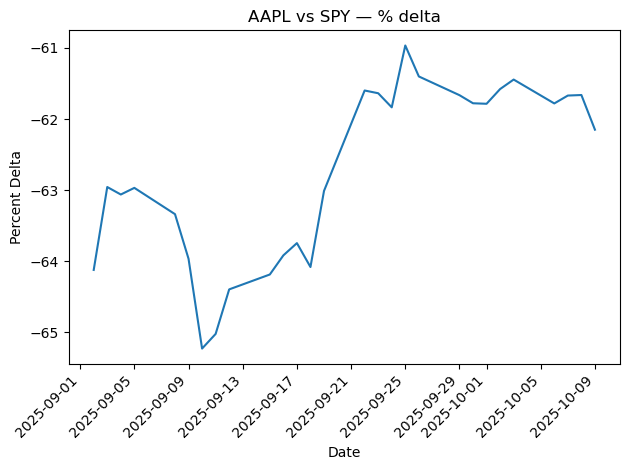

ticker is MSFT


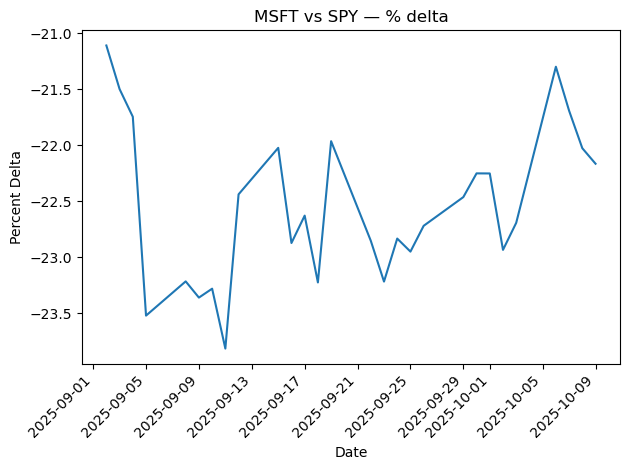

ticker is AMZN


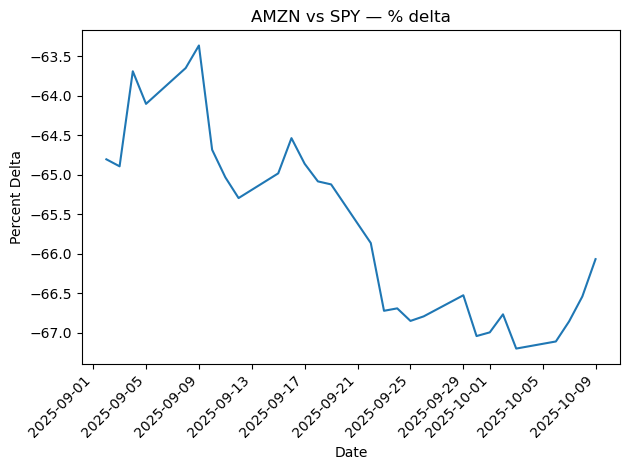

ticker is META


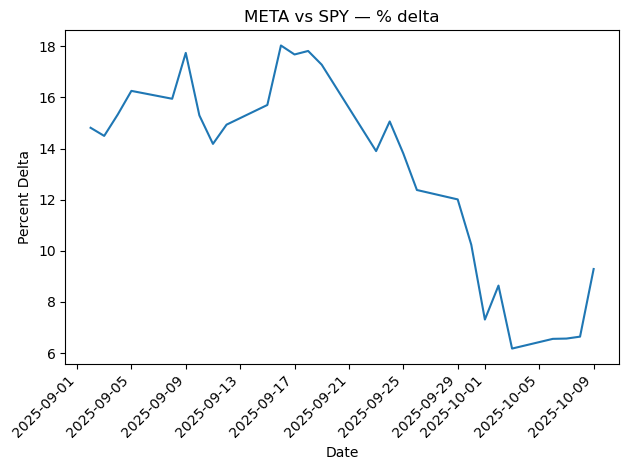

ticker is AVGO


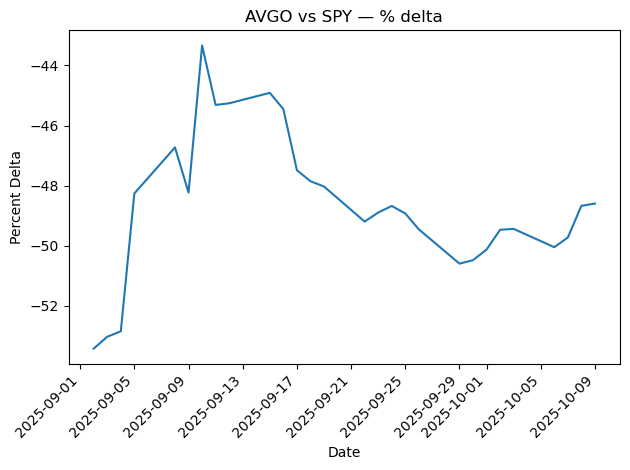

In [ ]:
import boto3, polars as pl
from boto3.dynamodb.conditions import Key
from decimal import Decimal
import matplotlib.pyplot as plt

#print("hello world")

def query_prices(table, ticker, start_date, end_date):
    resp = table.query(
        KeyConditionExpression=Key("ticker").eq(ticker) & Key("date").between(start_date, end_date),
        ProjectionExpression="ticker, #d, price",
        ExpressionAttributeNames={"#d": "date"},
    )
    items = resp["Items"]

    # dynamoDB pull has 1MB per
    while "LastEvaluatedKey" in resp:
        resp = table.query(
            KeyConditionExpression=Key("ticker").eq(ticker) & Key("date").between(start_date, end_date),
            ProjectionExpression="ticker, #d, price",
            ExpressionAttributeNames={"#d": "date"},
            ExclusiveStartKey=resp["LastEvaluatedKey"],
        )
        items.extend(resp["Items"])
    
    df = pl.from_dicts(items)
    return df.with_columns(pl.col("price").cast(pl.Float64))

def delta_vs_spy(df_tgt, df_spy):
    df_t = df_tgt.select(pl.col("date"), pl.col("price").alias("price_tgt"))
    df_s = df_spy.select(pl.col("date"), pl.col("price").alias("price_spy"))

    out = (

        # inner join based on date
            # match the same
        df_t.join(df_s, on="date", how="inner")
            .with_columns([
                (pl.col("price_tgt") - pl.col("price_spy")).alias("delta_abs"),
                ((pl.col("price_tgt") / pl.col("price_spy") - 1.0) * 100).alias("delta_pct"),
                pl.col("date")
                    .str.to_datetime(format="%+", time_zone="UTC", strict=False)
                    .alias("ts")
            ])
            .sort("ts")
    )
    return out


def list_tables(sess):
    ddb = sess.client("dynamodb")
    print(ddb.list_tables(Limit=2))  # proves access + region
    print()

sts = boto3.client("sts")
#print(sts.get_caller_identity())

session = boto3.Session(profile_name="default", region_name="us-west-2")
dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('stock-data-dev')


#print("check tables")
#list_tables(session)


# ---
START = "2025-09-02T00:00:00+00:00"
END = "2025-10-10T00:00:00+00:00"
TICKERS = ["NVDA","AAPL","MSFT","AMZN","META","AVGO"]



df_spy = query_prices(table, "SPY", START, END)

for tkr in TICKERS:
    print(f"ticker is {tkr}")
    df_tgt = query_prices(table, tkr, START, END)
    if df_tgt.is_empty() or df_spy.is_empty():
        print(f"{tkr}: no data in range; investigate")
        continue
    #print(df_spy.shape)
    #print(df_tgt.shape)

    delta = delta_vs_spy(df_tgt, df_spy)
    if delta.is_empty():
        print(f"{tkr}: no overlapping dates with SPY; investigate")
        continue

    #print(delta.shape)
    #print(delta.dtypes)
    #print(delta)


    # Plot percent delta
    plt.figure()
    plt.plot(delta["ts"].to_list(), delta["delta_pct"].to_list())
    plt.title(f"{tkr} vs SPY — % delta")
    plt.xlabel("Date")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Percent Delta")
    plt.tight_layout()
    plt.show()